# Win determination based on player's performance

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from tensorflow import keras

from neuralol.constants import Role, StatsCols, Models
from neuralol.data import get_model_players_game_features, role_train_val_test_split

pd.set_option('display.max_columns', None)

## Load data

In [2]:
df_processed_data = pd.read_csv('../data/preprocessed/standardized_game_players_stats.csv')
df_processed_data.head(5)

,game_id,player_id,player_name,team_id,team_name,role,win,champion_name,KLA,objectives_control,tower_control,gold_per_min,level_per_min,team_kills_per_min,largest_killing_spree,largest_multi_kill,cs_per_min,total_damage_per_min,damage_to_champions_per_min,damage_taken_per_min
0,15,0,shanji,0,Legend Esport Gaming,Top,False,Irelia,-0.846314,-1.388977,-0.875536,0.019869,0.572056,-0.597098,-0.783532,-0.072439,0.380168,-0.249262,-0.378994,0.175497
1,15,1,Demon,1,Bilibili Gaming Junior,Top,True,Vladimir,-0.447897,0.497790,0.319268,0.037037,1.822420,1.148377,0.105111,-0.072439,0.311517,-0.226542,0.133299,0.364045
2,15,2,yanxuan,0,Legend Esport Gaming,Bot,False,Kai'Sa,-0.713509,-1.388977,-0.875536,0.551087,0.572056,-0.597098,-0.783532,-0.072439,1.039212,0.046865,-0.538234,-1.389668
3,15,3,Viod,0,Legend Esport Gaming,Support,False,Lux,-0.872876,-1.388977,-0.875536,-1.494814,-0.678308,-0.597098,-0.783532,-1.272785,-1.816648,-1.533365,-0.901239,-1.330101
4,15,4,HanXuan,1,Bilibili Gaming Junior,Mid,True,Aatrox,-0.270823,0.497790,0.319268,0.802226,1.822420,1.148377,0.549433,1.127907,0.503738,0.193482,0.114441,0.200932


## Model training

In [3]:
def train_random_forest(X_train: pd.DataFrame, y_train: pd.DataFrame, param_grid=None, cv=3) -> tuple[RandomForestClassifier, dict]:
    """Train and tune a Random Forest model"""
    if param_grid is None:
        param_grid = {
            'n_estimators': [200, 300],
            'max_depth': [5, 10],
            'min_samples_split': [2, 5, 10]
        }
    
    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    return grid_search.best_estimator_, grid_search.best_params_

def train_xgboost(X_train: pd.DataFrame, y_train: pd.DataFrame, param_grid=None, cv=5) -> tuple[XGBClassifier, dict]:
    """Train and tune an XGBoost model"""
    if param_grid is None:
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.2]
        }
    
    xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
    grid_search = GridSearchCV(xgb_model, param_grid, cv=cv, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    return grid_search.best_estimator_, grid_search.best_params_

def train_dnn(X_train: pd.DataFrame, y_train: pd.DataFrame, X_val: pd.DataFrame, y_val: pd.DataFrame, param_grid=None) -> tuple:
    """Train and tune a Deep Neural Network model"""
    if param_grid is None:
        param_grid = {
            'neurons': [64, 128],
            'dropout': [0.3, 0.4],
            'learning_rate': [0.01, 0.005, 0.001]
        }
    
    input_dim = X_train.shape[1]
    best_model = None
    best_val_accuracy = 0
    best_history = None
    best_params = {}
    
    # Try different hyperparameter combinations
    for neurons in param_grid['neurons']:
        for dropout in param_grid['dropout']:
            for lr in param_grid['learning_rate']:
                # Create model
                model = keras.Sequential([
                    keras.Input(shape=[input_dim]),
                    keras.layers.Dense(neurons, activation='relu', kernel_regularizer=keras.regularizers.L2(0.1)),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dropout(dropout),
                    keras.layers.Dense(neurons//2, activation='relu', kernel_regularizer=keras.regularizers.L2(0.1)),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dropout(dropout),
                    keras.layers.Dense(neurons//2, activation='relu', kernel_regularizer=keras.regularizers.L2(0.1)),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dropout(dropout),
                    keras.layers.Dense(1, activation='sigmoid')
                ])
                
                model.compile(
                    optimizer=keras.optimizers.Adam(learning_rate=lr),
                    loss='binary_crossentropy',
                    metrics=['accuracy']
                )
                
                # Early stopping
                early_stop = keras.callbacks.EarlyStopping(
                    monitor='val_accuracy',
                    patience=10,
                    restore_best_weights=True
                )
                
                # Train model
                history = model.fit(
                    X_train, y_train,
                    epochs=200,
                    batch_size=256,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop],
                    verbose=0
                )
                
                # Get validation accuracy from the best epoch
                val_accuracy = max(history.history['val_accuracy'])
                
                if val_accuracy > best_val_accuracy:
                    best_val_accuracy = val_accuracy
                    best_model = model
                    best_history = history
                    best_params = {'neurons': neurons, 'dropout': dropout, 'learning_rate': lr}
                
                print(".", end='')
    print()
    
    return best_model, best_params, best_history

## Models training

In [4]:
def train_models(X_train: pd.DataFrame, y_train: pd.DataFrame, X_val: pd.DataFrame, y_val: pd.DataFrame, role: str):
    """
    Train multiple models and evaluate them once without cross-validation.
    
    Parameters:
    -----------
    X_train_val : pd.DataFrame
        Features for training and validation
    y_train_val : pd.DataFrame
        Target variable for training and validation
    role : str
        Role being modeled
    test_size : float, default=0.2
        Proportion of data to use for validation
    random_state : int, default=42
        Random seed for reproducibility
    
    Returns:
    --------
    dict
        Results for each model type, including performance metrics and best models
    """
    # Store results for each model type
    results = {
        Models.RANDOM_FOREST: {'train_acc': 0, 'val_acc': 0, 'best_model': None, 'best_params': None},
        Models.XGBOOST: {'train_acc': 0, 'val_acc': 0, 'best_model': None, 'best_params': None},
        Models.DNN: {'train_acc': 0, 'val_acc': 0, 'best_model': None, 'best_params': None, 'history': None},
        'best_model_type': ''
    }
    
    print(f"\nTraining models for {role} role...")
    
    # Train Random Forest
    print("Training Random Forest...")
    rf_model, rf_params = train_random_forest(X_train, y_train)
    rf_train_acc = rf_model.score(X_train, y_train)
    rf_val_acc = rf_model.score(X_val, y_val)
    results[Models.RANDOM_FOREST]['train_acc'] = rf_train_acc
    results[Models.RANDOM_FOREST]['val_acc'] = rf_val_acc
    results[Models.RANDOM_FOREST]['best_model'] = rf_model
    results[Models.RANDOM_FOREST]['best_params'] = rf_params
    
    # Train XGBoost
    print("Training XGBoost...")
    xgb_model, xgb_params = train_xgboost(X_train, y_train)
    xgb_train_acc = xgb_model.score(X_train, y_train)
    xgb_val_acc = xgb_model.score(X_val, y_val)
    results[Models.XGBOOST]['train_acc'] = xgb_train_acc
    results[Models.XGBOOST]['val_acc'] = xgb_val_acc
    results[Models.XGBOOST]['best_model'] = xgb_model
    results[Models.XGBOOST]['best_params'] = xgb_params
    
    # Train DNN
    print("Training DNN...")
    dnn_model, dnn_params, history = train_dnn(X_train, y_train, X_val, y_val)
    dnn_train_acc = dnn_model.evaluate(X_train, y_train, verbose=0)[1]
    dnn_val_acc = dnn_model.evaluate(X_val, y_val, verbose=0)[1]
    results[Models.DNN]['train_acc'] = dnn_train_acc
    results[Models.DNN]['val_acc'] = dnn_val_acc
    results[Models.DNN]['best_model'] = dnn_model
    results[Models.DNN]['best_params'] = dnn_params
    results[Models.DNN]['history'] = history
    
    # Print results for each model
    for model_type in Models.LIST:
        print(f"{model_type} - Train Accuracy: {results[model_type]['train_acc']:.4f}, Validation Accuracy: {results[model_type]['val_acc']:.4f}")
        print(f"Best Parameters: {results[model_type]['best_params']}")
    
    # Find the best model type based on validation accuracy
    best_model_type = max(Models.LIST, key=lambda x: results[x]['val_acc'])
    results['best_model_type'] = best_model_type
    print(f"\nBest Model for {role}: {best_model_type}")
    print(f"Train Accuracy: {results[best_model_type]['train_acc']:.4f}")
    print(f"Validation Accuracy: {results[best_model_type]['val_acc']:.4f}")
    
    return results

## Plots

In [5]:
def plot_learning_curves(history, role: str) -> None:
    """
    Plot accuracy and loss curves for a provided training history.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Train')
    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title(f'DNN Accuracy for {role} role', fontsize=16, fontweight='bold')
    ax1.set_xlabel('Epochs', fontsize=14)
    ax1.set_ylabel('Accuracy', fontsize=14)
    ax1.legend()
    ax1.grid(True, linestyle="--", alpha=0.7)
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Train')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title(f'DNN Loss for {role} role', fontsize=16, fontweight='bold')
    ax2.set_xlabel('Epochs', fontsize=14)
    ax2.set_ylabel('Loss', fontsize=14)
    ax2.legend()
    ax2.grid(True, linestyle="--", alpha=0.7)
    
    plt.tight_layout()
    plt.show()

def plot_models_comparison(results: dict) -> None:
    """
    Plot comparison of different models training and validation accuracies.
    """
    model_types = Models.LIST
    
    # Prepare data for plotting
    train_accuracies = [results[model_type]['train_acc'] for model_type in model_types]
    val_accuracies = [results[model_type]['val_acc'] for model_type in model_types]
    
    # Set up the figure
    plt.figure(figsize=(10, 6))
    
    # Create positions for bars
    x = np.arange(len(model_types))
    bar_width = 0.20
    
    # Create bars
    plt.bar(x - bar_width/2, train_accuracies, width=bar_width, label='Training', alpha=0.8)
    plt.bar(x + bar_width/2, val_accuracies, width=bar_width, label='Validation', alpha=0.8)
    
    # Add labels and customize
    plt.xlabel('Model Type', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.title('Model Comparison: Training vs Validation Accuracy', fontsize=16, fontweight='bold')
    plt.xticks(x, model_types, fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, 1.0)
    
    # Add value labels on top of bars
    for i, v in enumerate(train_accuracies):
        plt.text(i - bar_width/2, v + 0.01, f'{v:.3f}', ha='center', fontsize=10)
    
    for i, v in enumerate(val_accuracies):
        plt.text(i + bar_width/2, v + 0.01, f'{v:.3f}', ha='center', fontsize=10)
    
    plt.tight_layout()

## Win prediction

In [6]:
def predict_win(model: RandomForestClassifier | XGBClassifier | keras.Sequential, X_test: pd.DataFrame, y_test: pd.DataFrame, return_proba: bool = True) -> tuple:
    """
    Predict win using the given model and calculate accuracy.
    
    Parameters:
    -----------
    model : trained model
        Model with predict or predict_proba methods
    X_test : pd.DataFrame
        Test data
    y_test : pd.DataFrame
        Test target
    return_proba : bool
        Whether to return probabilities
        
    Returns:
    --------
    tuple
        (Predictions, Probabilities, Accuracy) if return_proba=True, else (Predictions, Accuracy)
    """
    try:
        # Try Keras-style prediction first (returns probabilities directly)
        probas = model.predict(X_test).flatten()
        preds = (probas > 0.5)
    except (AttributeError, ValueError, TypeError):
        try:
            # Try scikit-learn style with predict_proba
            probas = model.predict_proba(X_test)[:, 1]
            preds = (probas > 0.5)
        except (AttributeError, ValueError):
            # Fallback to direct prediction
            preds = model.predict(X_test)
            probas = None
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, preds)
    
    if return_proba and probas is not None:
        return preds, probas, accuracy
    else:
        return preds, accuracy

## Model saving

In [7]:
import os
import joblib

def save_model(model, model_type: str, role: str) -> None:
    model_dir = "../data/best_models"
    # Create directory if it doesn't exist
    os.makedirs(model_dir, exist_ok=True)

    model_filename = f"{role.lower()}_model"

    # Save the model based on its type
    if model_type == Models.DNN:
        # Save Keras model
        model.save(f"{model_dir}/{model_filename}.keras")
        print(f"Saved {model_type} model to {model_dir}/{model_filename}.keras")
    else:
        # Save scikit-learn based models
        joblib.dump(model, f"{model_dir}/{model_filename}.pkl")
        print(f"Saved {model_type} model to {model_dir}/{model_filename}.pkl")

## Top Role

### Training

In [8]:
top_X_train, top_X_val, top_X_test, top_y_train, top_y_val, top_y_test = role_train_val_test_split(df_processed_data, Role.TOP, val_size=0.15, test_size=0.10)

# Create feature list for TOP role model
top_role_input_features = get_model_players_game_features(Role.TOP)
top_results = train_models(top_X_train[top_role_input_features], top_y_train, top_X_val[top_role_input_features], top_y_val, Role.TOP)

,Split,Samples,Proportion (%)
0,Training set,56160,75.0
1,Validation set,11232,15.0
2,Test set,7489,10.0
3,Total,74881,100.0



Training models for Top role...
Training Random Forest...
Training XGBoost...
Training DNN...
............
RandomForest - Train Accuracy: 0.9131, Validation Accuracy: 0.8962
Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 300}
XGBoost - Train Accuracy: 0.9049, Validation Accuracy: 0.8993
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
DNN - Train Accuracy: 0.8954, Validation Accuracy: 0.8991
Best Parameters: {'neurons': 128, 'dropout': 0.3, 'learning_rate': 0.001}

Best Model for Top: XGBoost
Train Accuracy: 0.9049
Validation Accuracy: 0.8993


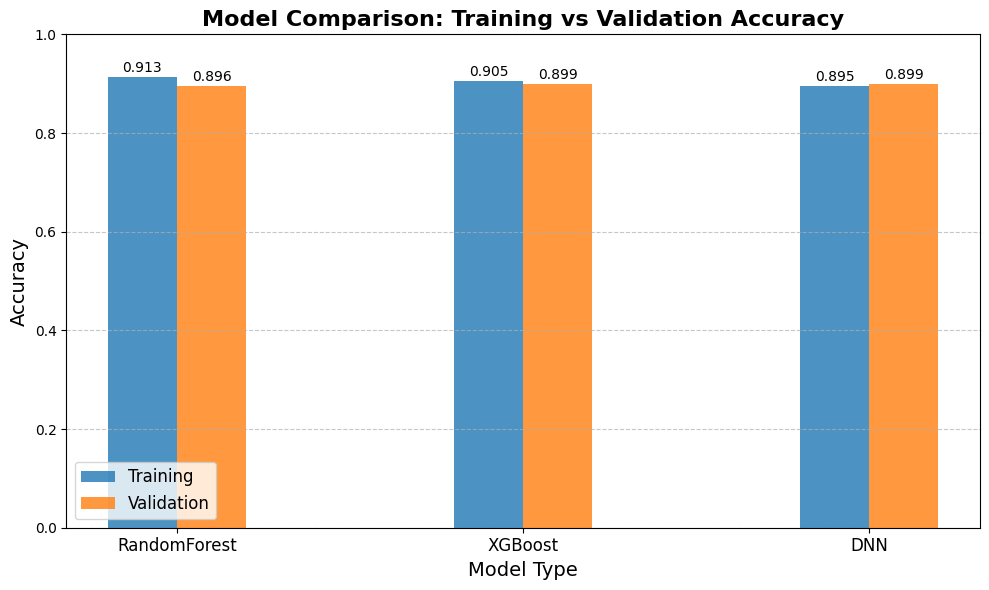

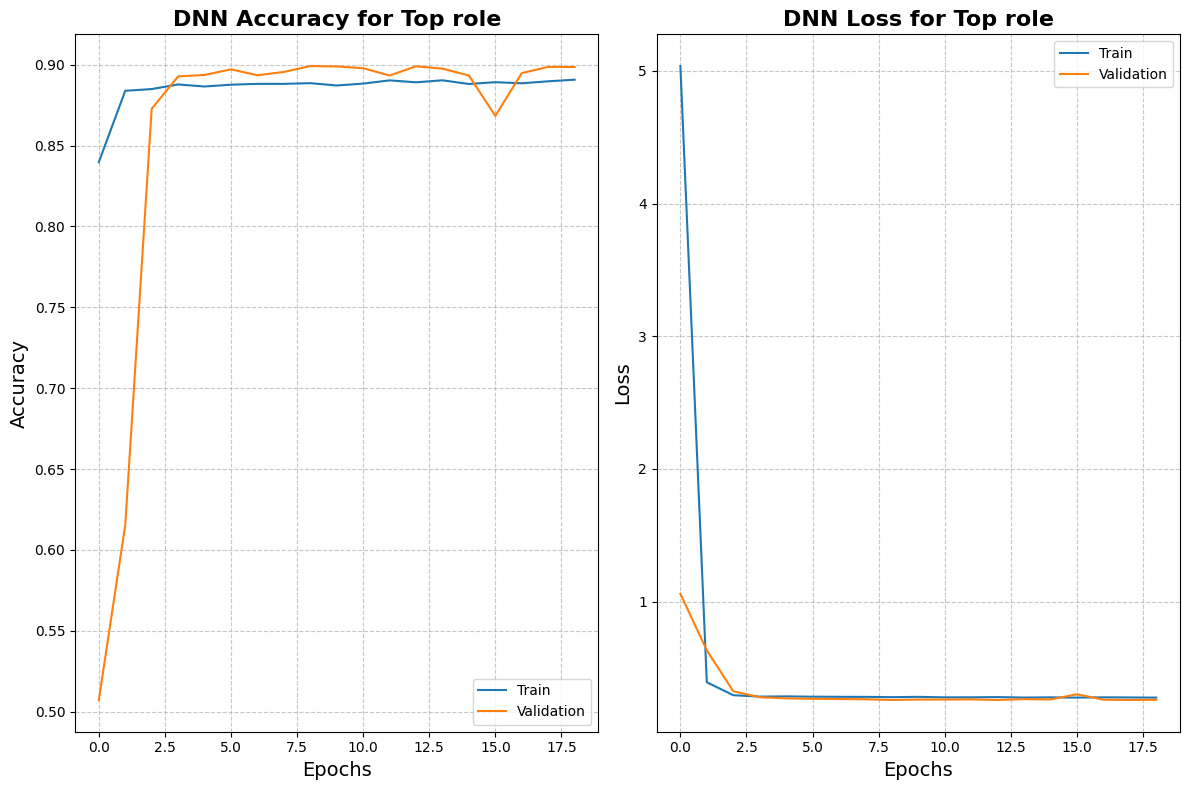

In [9]:
plot_models_comparison(top_results)
plot_learning_curves(top_results[Models.DNN]['history'], Role.TOP)

### Testing

In [10]:
# Get the best model for TOP role
top_best_model_type = top_results['best_model_type']
top_best_model = top_results[top_best_model_type]['best_model']
print(f"Using {top_best_model_type} model for prediction")

# Get a single player game for demonstration
top_test_player = top_X_test.iloc[[0]]
top_player_target = top_y_test.iloc[[0]]
# Make prediction for single player
top_player_pred, top_player_prob, top_player_acc = predict_win(top_best_model, top_test_player[top_role_input_features], top_player_target)

# Display player details and prediction
print(f"\nSingle Player Prediction:")
print(f"ID: {top_test_player[StatsCols.PLAYER_ID].values[0]}, Name: {top_test_player[StatsCols.PLAYER_NAME].values[0]}, Role: {top_test_player[StatsCols.ROLE].values[0]}")
print(f"Win: {top_test_player[StatsCols.WIN].values[0]}, Predicted Win: {bool(top_player_pred[0])}, Probability: {top_player_prob[0]:.4f}, Accuracy: {top_player_acc:.4f}")

# Run prediction on entire test set and show accuracy
top_test_preds, top_test_probs, test_accuracy = predict_win(top_best_model, top_X_test[top_role_input_features], top_y_test)
print(f"\nOverall Test Accuracy for TOP role: {test_accuracy:.4f}")

Using XGBoost model for prediction

Single Player Prediction:
ID: 3044, Name: SuperCleber, Role: Top
Win: True, Predicted Win: True, Probability: 1.0000, Accuracy: 1.0000

Overall Test Accuracy for TOP role: 0.8981


### Saving best model

In [ ]:
save = False
if save:
    save_model(top_best_model, top_best_model_type, Role.TOP)

Saved XGBoost model to ../data/best_models/top_model.pkl


## Jungle Role

### Training

In [12]:
jungle_X_train, jungle_X_val, jungle_X_test, jungle_y_train, jungle_y_val, jungle_y_test = role_train_val_test_split(df_processed_data, Role.JUNGLE, val_size=0.15, test_size=0.10)

# Create feature list for TOP role model
jungle_role_input_features = get_model_players_game_features(Role.JUNGLE)
jungle_results = train_models(jungle_X_train[jungle_role_input_features], jungle_y_train, jungle_X_val[jungle_role_input_features], jungle_y_val, Role.JUNGLE)

,Split,Samples,Proportion (%)
0,Training set,56160,75.0
1,Validation set,11233,15.0
2,Test set,7489,10.0
3,Total,74882,100.0



Training models for Jungle role...
Training Random Forest...
Training XGBoost...
Training DNN...
............
RandomForest - Train Accuracy: 0.9228, Validation Accuracy: 0.9057
Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 300}
XGBoost - Train Accuracy: 0.9130, Validation Accuracy: 0.9112
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
DNN - Train Accuracy: 0.9052, Validation Accuracy: 0.9096
Best Parameters: {'neurons': 64, 'dropout': 0.3, 'learning_rate': 0.001}

Best Model for Jungle: XGBoost
Train Accuracy: 0.9130
Validation Accuracy: 0.9112


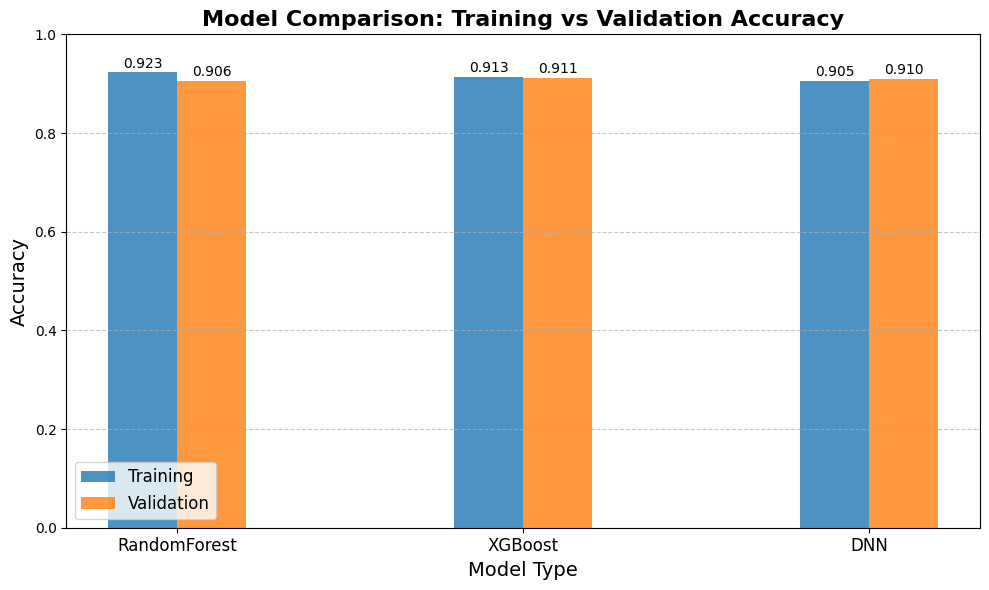

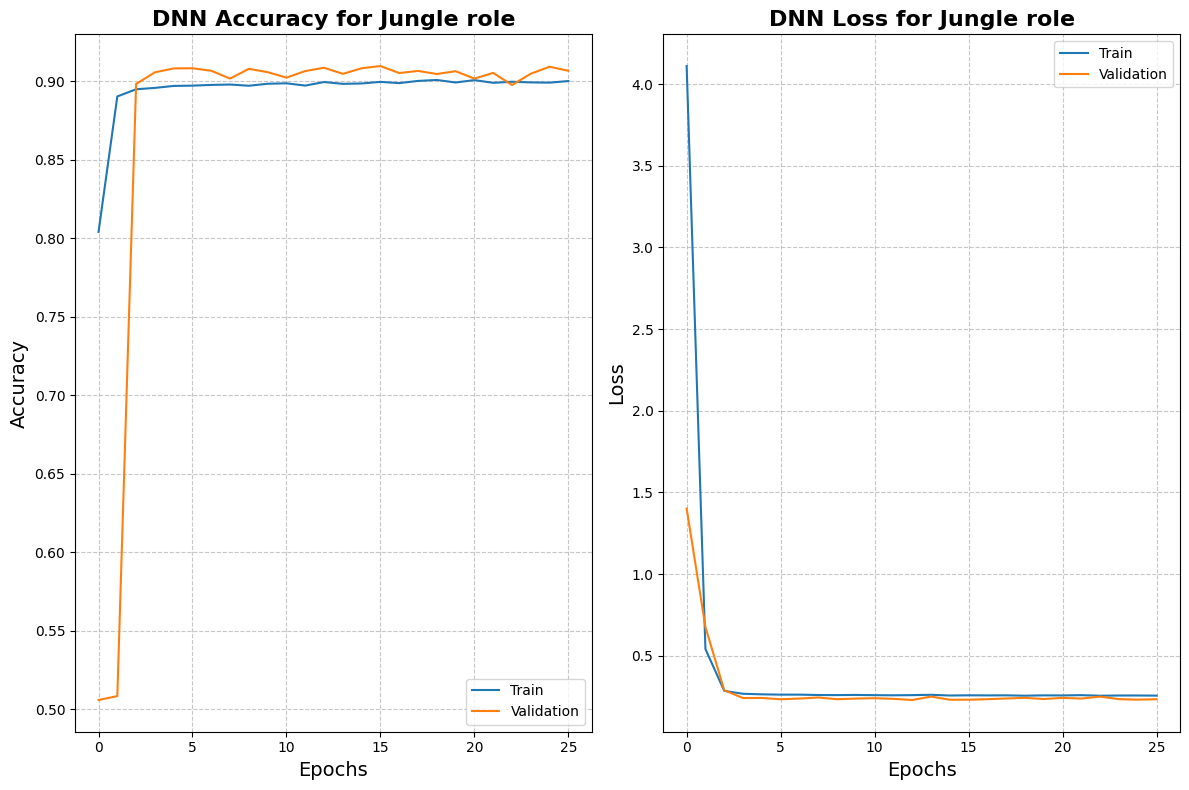

In [13]:
plot_models_comparison(jungle_results)
plot_learning_curves(jungle_results[Models.DNN]['history'], Role.JUNGLE)

### Testing

In [14]:
# Get the best model for TOP role
jungle_best_model_type = jungle_results['best_model_type']
jungle_best_model = jungle_results[jungle_best_model_type]['best_model']
print(f"Using {jungle_best_model_type} model for prediction")

# Get a single player game for demonstration
jungle_test_player = jungle_X_test.iloc[[0]]
jungle_player_target = jungle_y_test.iloc[[0]]
# Make prediction for single player
jungle_player_pred, jungle_player_prob, jungle_player_acc = predict_win(jungle_best_model, jungle_test_player[jungle_role_input_features], jungle_player_target)

# Display player details and prediction
print(f"\nSingle Player Prediction:")
print(f"ID: {jungle_test_player[StatsCols.PLAYER_ID].values[0]}, Name: {jungle_test_player[StatsCols.PLAYER_NAME].values[0]}, Role: {jungle_test_player[StatsCols.ROLE].values[0]}")
print(f"Win: {jungle_test_player[StatsCols.WIN].values[0]}, Predicted Win: {bool(jungle_player_pred[0])}, Probability: {jungle_player_prob[0]:.4f}, Accuracy: {jungle_player_acc:.4f}")

# Run prediction on entire test set and show accuracy
jungle_test_preds, jungle_test_probs, test_accuracy = predict_win(jungle_best_model, jungle_X_test[jungle_role_input_features], jungle_y_test)
print(f"\nOverall Test Accuracy for TOP role: {test_accuracy:.4f}")

Using XGBoost model for prediction

Single Player Prediction:
ID: 2669, Name: Samkz, Role: Jungle
Win: True, Predicted Win: True, Probability: 1.0000, Accuracy: 1.0000

Overall Test Accuracy for TOP role: 0.9061


### Saving best model

In [ ]:
save = False
if save:
    save_model(jungle_best_model, jungle_best_model_type, Role.JUNGLE)

Saved XGBoost model to ../data/best_models/jungle_model.pkl


## Mid Role

### Training

In [ ]:
mid_X_train, mid_X_val, mid_X_test, mid_y_train, mid_y_val, mid_y_test = role_train_val_test_split(df_processed_data, Role.MID, val_size=0.15, test_size=0.10)

# Create feature list for MID role model
mid_role_input_features = get_model_players_game_features(Role.MID)
mid_results = train_models(mid_X_train[mid_role_input_features], mid_y_train, mid_X_val[mid_role_input_features], mid_y_val, Role.MID)

,Split,Samples,Proportion (%)
0,Training set,56160,75.0
1,Validation set,11233,15.0
2,Test set,7489,10.0
3,Total,74882,100.0



Training models for Mid role...
Training Random Forest...
Training XGBoost...
Training DNN...
............
RandomForest - Train Accuracy: 0.9184, Validation Accuracy: 0.9020
Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 300}
XGBoost - Train Accuracy: 0.9122, Validation Accuracy: 0.9069
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
DNN - Train Accuracy: 0.9021, Validation Accuracy: 0.9088
Best Parameters: {'neurons': 128, 'dropout': 0.3, 'learning_rate': 0.001}

Best Model for Mid: DNN
Train Accuracy: 0.9021
Validation Accuracy: 0.9088


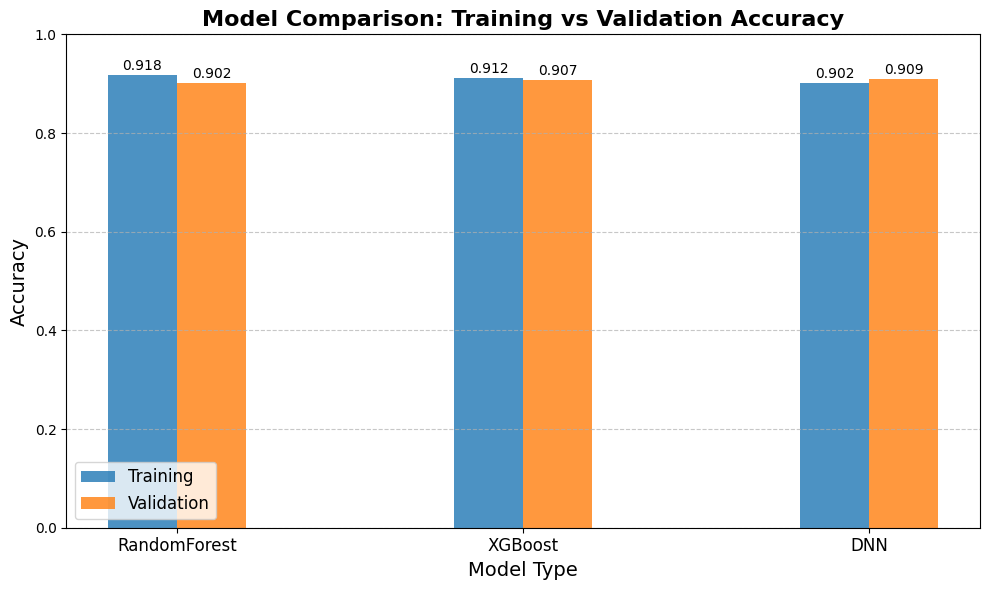

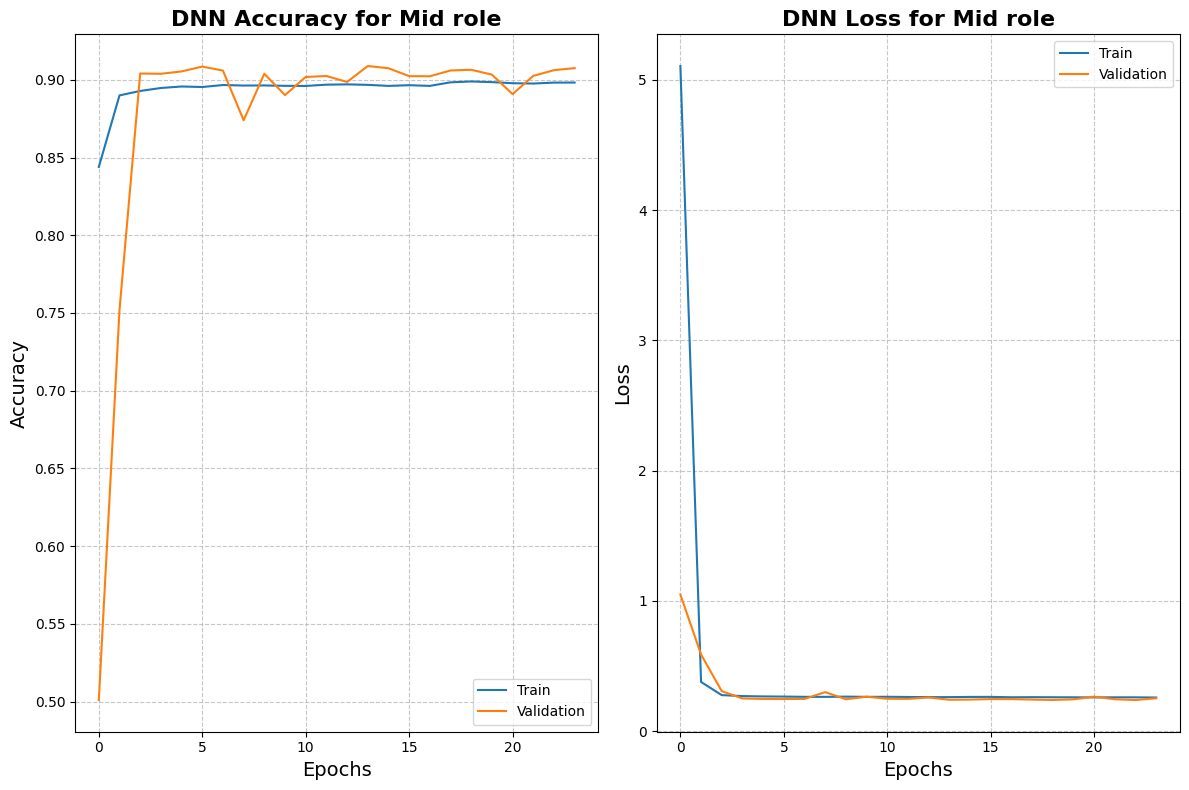

In [17]:
plot_models_comparison(mid_results)
plot_learning_curves(mid_results[Models.DNN]['history'], Role.MID)

### Testing

In [18]:
# Get the best model for MID role
mid_best_model_type = mid_results['best_model_type']
mid_best_model = mid_results[mid_best_model_type]['best_model']
print(f"Using {mid_best_model_type} model for prediction")

# Get a single player game for demonstration
mid_test_player = mid_X_test.iloc[[0]]
mid_player_target = mid_y_test.iloc[[0]]
# Make prediction for single player
mid_player_pred, mid_player_prob, mid_player_acc = predict_win(mid_best_model, mid_test_player[mid_role_input_features], mid_player_target)

# Display player details and prediction
print(f"\nSingle Player Prediction:")
print(f"ID: {mid_test_player[StatsCols.PLAYER_ID].values[0]}, Name: {mid_test_player[StatsCols.PLAYER_NAME].values[0]}, Role: {mid_test_player[StatsCols.ROLE].values[0]}")
print(f"Win: {mid_test_player[StatsCols.WIN].values[0]}, Predicted Win: {bool(mid_player_pred[0])}, Probability: {mid_player_prob[0]:.4f}, Accuracy: {mid_player_acc:.4f}")

# Run prediction on entire test set and show accuracy
mid_test_preds, mid_test_probs, test_accuracy = predict_win(mid_best_model, mid_X_test[mid_role_input_features], mid_y_test)
print(f"\nOverall Test Accuracy for TOP role: {test_accuracy:.4f}")

Using DNN model for prediction
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step

Single Player Prediction:
ID: 3900, Name: Picknn, Role: Mid
Win: False, Predicted Win: False, Probability: 0.0068, Accuracy: 1.0000
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step

Overall Test Accuracy for TOP role: 0.8969


### Saving best model

In [ ]:
save = False
if save:
    save_model(mid_best_model, mid_best_model_type, Role.MID)

Saved DNN model to ../data/best_models/mid_model.keras


## Bot Role

### Training

In [20]:
bot_X_train, bot_X_val, bot_X_test, bot_y_train, bot_y_val, bot_y_test = role_train_val_test_split(df_processed_data, Role.BOT, val_size=0.15, test_size=0.10)

# Create feature list for BOT role model
bot_role_input_features = get_model_players_game_features(Role.BOT)
bot_results = train_models(bot_X_train[bot_role_input_features], bot_y_train, bot_X_val[bot_role_input_features], bot_y_val, Role.BOT)

,Split,Samples,Proportion (%)
0,Training set,56158,75.0
1,Validation set,11232,15.0
2,Test set,7488,10.0
3,Total,74878,100.0



Training models for Bot role...
Training Random Forest...
Training XGBoost...
Training DNN...
............
RandomForest - Train Accuracy: 0.9306, Validation Accuracy: 0.9097
Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
XGBoost - Train Accuracy: 0.9252, Validation Accuracy: 0.9166
Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
DNN - Train Accuracy: 0.9155, Validation Accuracy: 0.9140
Best Parameters: {'neurons': 64, 'dropout': 0.3, 'learning_rate': 0.001}

Best Model for Bot: XGBoost
Train Accuracy: 0.9252
Validation Accuracy: 0.9166


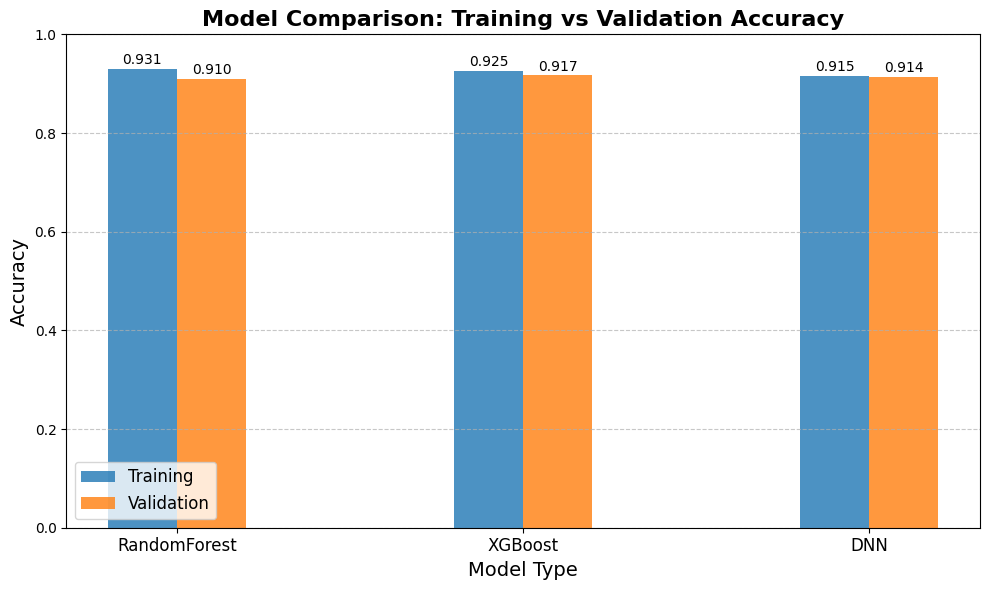

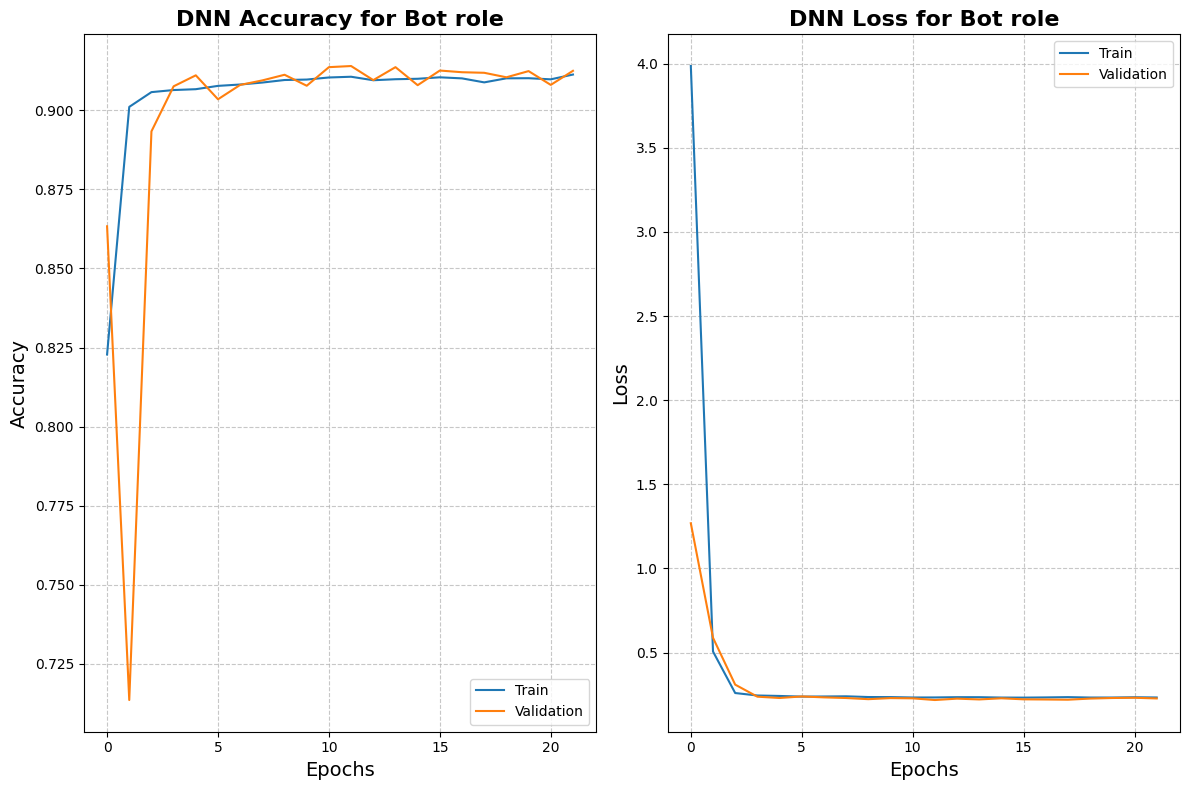

In [21]:
plot_models_comparison(bot_results)
plot_learning_curves(bot_results[Models.DNN]['history'], Role.BOT)

### Testing

In [22]:
# Get the best model for BOT role
bot_best_model_type = bot_results['best_model_type']
bot_best_model = bot_results[bot_best_model_type]['best_model']
print(f"Using {bot_best_model_type} model for prediction")

# Get a single player game for demonstration
bot_test_player = bot_X_test.iloc[[0]]
bot_player_target = bot_y_test.iloc[[0]]
# Make prediction for single player
bot_player_pred, bot_player_prob, bot_player_acc = predict_win(bot_best_model, bot_test_player[bot_role_input_features], bot_player_target)

# Display player details and prediction
print(f"\nSingle Player Prediction:")
print(f"ID: {bot_test_player[StatsCols.PLAYER_ID].values[0]}, Name: {bot_test_player[StatsCols.PLAYER_NAME].values[0]}, Role: {bot_test_player[StatsCols.ROLE].values[0]}")
print(f"Win: {bot_test_player[StatsCols.WIN].values[0]}, Predicted Win: {bool(bot_player_pred[0])}, Probability: {bot_player_prob[0]:.4f}, Accuracy: {bot_player_acc:.4f}")

# Run prediction on entire test set and show accuracy
bot_test_preds, bot_test_probs, test_accuracy = predict_win(bot_best_model, bot_X_test[bot_role_input_features], bot_y_test)
print(f"\nOverall Test Accuracy for TOP role: {test_accuracy:.4f}")

Using XGBoost model for prediction

Single Player Prediction:
ID: 721, Name: SSol, Role: Bot
Win: False, Predicted Win: False, Probability: 0.0000, Accuracy: 1.0000

Overall Test Accuracy for TOP role: 0.9160


### Saving best model

In [ ]:
save = False
if save:
    save_model(bot_best_model, bot_best_model_type, Role.BOT)

Saved XGBoost model to ../data/best_models/bot_model.pkl


## Support Role

### Training

In [24]:
sup_X_train, sup_X_val, sup_X_test, sup_y_train, sup_y_val, sup_y_test = role_train_val_test_split(df_processed_data, Role.SUPPORT, val_size=0.15, test_size=0.10)

# Create feature list for SUPPORT role model
sup_role_input_features = get_model_players_game_features(Role.SUPPORT)
sup_results = train_models(sup_X_train[sup_role_input_features], sup_y_train, sup_X_val[sup_role_input_features], sup_y_val, Role.SUPPORT)

,Split,Samples,Proportion (%)
0,Training set,55916,75.0
1,Validation set,11184,15.0
2,Test set,7456,10.0
3,Total,74556,100.0



Training models for Support role...
Training Random Forest...
Training XGBoost...
Training DNN...
............
RandomForest - Train Accuracy: 0.9154, Validation Accuracy: 0.8993
Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
XGBoost - Train Accuracy: 0.9066, Validation Accuracy: 0.9009
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
DNN - Train Accuracy: 0.9016, Validation Accuracy: 0.8987
Best Parameters: {'neurons': 128, 'dropout': 0.4, 'learning_rate': 0.001}

Best Model for Support: XGBoost
Train Accuracy: 0.9066
Validation Accuracy: 0.9009


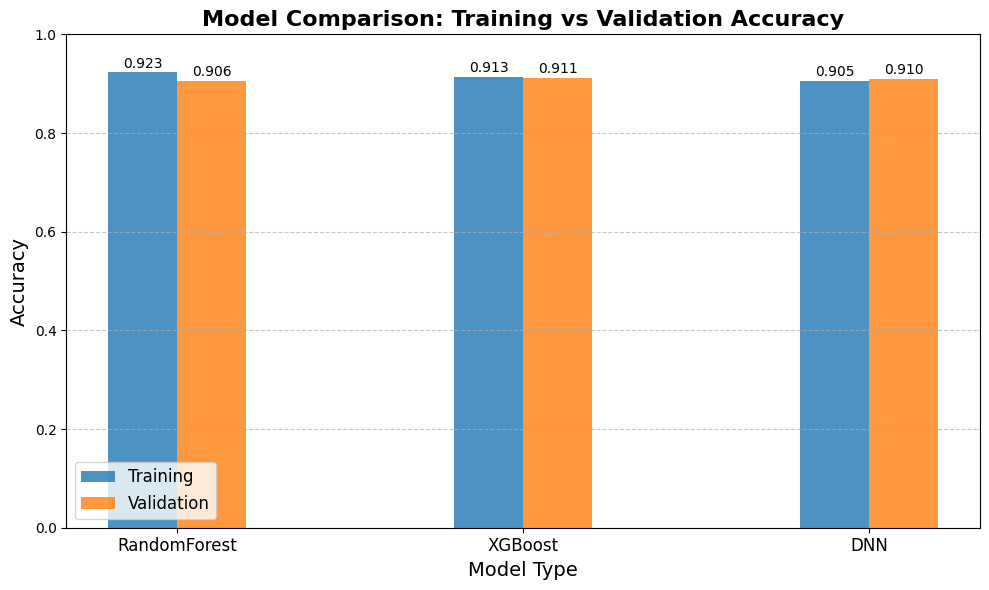

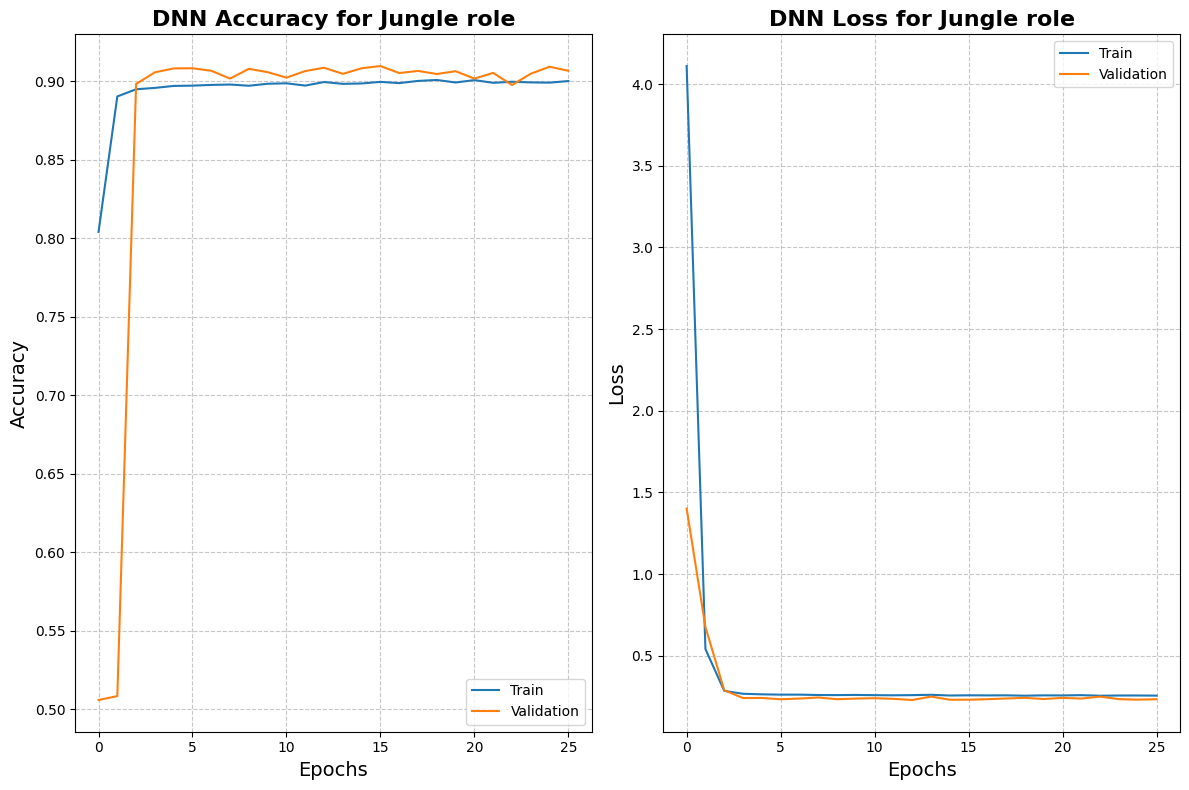

In [ ]:
plot_models_comparison(sup_results)
plot_learning_curves(sup_results[Models.DNN]['history'], Role.SUPPORT)

### Testing

In [25]:
# Get the best model for SUPPORT role
sup_best_model_type = sup_results['best_model_type']
sup_best_model = sup_results[sup_best_model_type]['best_model']
print(f"Using {sup_best_model_type} model for prediction")

# Get a single player game for demonstration
sup_test_player = sup_X_test.iloc[[0]]
sup_player_target = sup_y_test.iloc[[0]]
# Make prediction for single player
sup_player_pred, sup_player_prob, sup_player_acc = predict_win(sup_best_model, sup_test_player[sup_role_input_features], sup_player_target)

# Display player details and prediction
print(f"\nSingle Player Prediction:")
print(f"ID: {sup_test_player[StatsCols.PLAYER_ID].values[0]}, Name: {sup_test_player[StatsCols.PLAYER_NAME].values[0]}, Role: {sup_test_player[StatsCols.ROLE].values[0]}")
print(f"Win: {sup_test_player[StatsCols.WIN].values[0]}, Predicted Win: {bool(sup_player_pred[0])}, Probability: {sup_player_prob[0]:.4f}, Accuracy: {sup_player_acc:.4f}")

# Run prediction on entire test set and show accuracy
sup_test_preds, sup_test_probs, test_accuracy = predict_win(sup_best_model, sup_X_test[sup_role_input_features], sup_y_test)
print(f"\nOverall Test Accuracy for TOP role: {test_accuracy:.4f}")

Using XGBoost model for prediction

Single Player Prediction:
ID: 147, Name: SKasH, Role: Support
Win: False, Predicted Win: False, Probability: 0.0000, Accuracy: 1.0000

Overall Test Accuracy for TOP role: 0.9050


### Saving best model

In [ ]:
save = False
if save:
    save_model(sup_best_model, sup_best_model_type, Role.SUPPORT)

Saved XGBoost model to ../data/best_models/support_model.pkl
